In [28]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import pi, sqrt
from scipy.special import erf 
import os

## cnot

100000


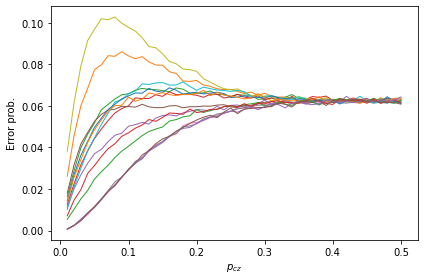

In [119]:
repeat = 100
pm_list =  [0.]

# plt.figure(1,figsize=(5,3))

for i_n, pm in enumerate(pm_list):
    first = True
    for i_rep in range(repeat):
        # fname = "data_dv_cnot/" + "pm_%.2f_i_%d.npz" % (pm,i_rep)
        fname = "data_dv_cnot/" + "pm_eq_pc_i_%d_mc.npz" % (i_rep)
    

        if os.path.exists(fname):
            npz_file = np.load(fname)
            pc_list, err_mc, Nrep = npz_file['pc_list'], npz_file['err_mc'], npz_file['Nrep']

            if first :
                first = False
                err_mc_avg = np.zeros((16,len(pc_list)))
                Ntot = 0

            err_mc_avg += err_mc*Nrep
            Ntot += Nrep
    if not first:
        err_mc_avg /= Ntot
        for i_xx in range(1,16):
            # plt.figure(i_xx)
            plt.plot(pc_list,err_mc_avg[i_xx,:],"-", color="C%d" % (i_xx), linewidth=1,label="MC, %d, %.2f" % (i_xx,pm))
            plt.xlabel(r"$p_{cz}$")
            plt.ylabel("Error prob.")
            # plt.grid()
            # plt.legend(frameon=False,markerscale=2)
            plt.tight_layout()
            # plt.grid()
            # plt.savefig("figs/qdot-threshold.pdf")
            # plt.show()
            
print(Ntot)

In [98]:

cnot = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])+0j

def pauli(s):
    s0 = np.matrix([[1.,0.],[0.,1.]])
    s1 = np.matrix([[0.,1.],[1.,0.]])
    s2 = np.matrix([[0.,-1.j],[1.j,0.]])
    s3 = np.matrix([[1.,0.],[0.,-1.]])
    if s == 'I':
        return s0 
    elif s =='X':
        return s1
    elif s == 'Y':
        return s2
    elif s == 'Z':
        return s3
    
def pauli_str_to_mat(string):
    U = pauli(string[0])
    for k in range(1,len(string)):
        U =np.kron(U, pauli(string[k]))
    return U

def error_channel(U_in, error_model):
    U_out = np.zeros([4,4])+0.j
    for i in range (16):
        U_out += error_model[i][1]*pauli_str_to_mat(error_model[i][0])@cnot@U_in@cnot@pauli_str_to_mat(error_model[i][0])
    return U_out

def fidelity_CNOT(error_model): # input a error model; out put the average fid. based on https://arxiv.org/pdf/quant-ph/0205035.pdf   
    err_list= {0: 'II', 1: 'ZI', 2: 'XI', 3: 'YI', 4: 'IZ', 5: 'ZZ', 6: 'XZ',\
          7: 'YZ', 8: 'IX', 9: 'ZX', 10: 'XX', 11: 'YX', 12: 'IY',\
          13: 'ZY', 14: 'XY', 15: 'YY'}
    fid = 0.2
    for i in range (16):
        U_in = pauli_str_to_mat(err_list[i])
        U_out = error_channel(U_in, error_model)
        fid += np.trace(cnot@np.conj(U_in.T)@cnot@U_out)/80
    return fid

In [121]:
# error_model = error_model_gkp(σc2, σgkp2, σm2, k=1, gate_type = 'CNOT')
err_list={0: 'II', 1: 'ZI', 2: 'XI', 3: 'YI', 4: 'IZ', 5: 'ZZ', 6: 'XZ',\
          7: 'YZ', 8: 'IX', 9: 'ZX', 10: 'XX', 11: 'YX', 12: 'IY',\
          13: 'ZY', 14: 'XY', 15: 'YY'}
    
fids_mc = []
for i_p, pc in enumerate(pc_list):
    err_model = []
    for i in range (16):
        err_model.append((err_list[i],err_mc_avg[i,i_p]))
    fids_mc.append(fidelity_CNOT(err_model))



[1.53147273e+01 7.63030303e-05]


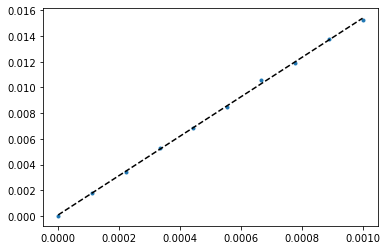

In [103]:
fids_mc_fine = np.real(np.array(fids_mc_fine))
plt.plot(pc_list,1-fids_mc_fine,".", label="Infidelity")

z = np.polyfit(pc_list, 1-fids_mc_fine, 1) 
print(z)
plt.plot(pc_list,z[0]*pc_list+z[1],"k--")

plt.show()

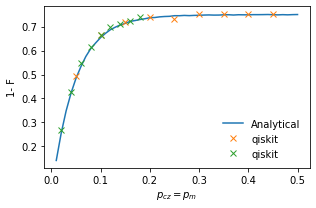

In [126]:
fids_mc = np.real(np.array(fids_mc))

plt.figure(figsize=(4.5,3))
plt.plot(pc_list,1-fids_mc,"-", label="Analytical")

pc_list_qiskit = np.arange(1,10,1)*0.05
inFid_qiskit = np.array([0.495 , 0.6654, 0.7203, 0.7403, 0.7323, 0.7539, 0.7523, 0.7529,
       0.7517])

pc_list_qiskit2 = np.arange(1,10,1)*0.02

Fid_qiskit = np.array([0.7306,
 0.5722,
 0.45260000000000006,
 0.3858,
 0.33599999999999997,
 0.3024,
 0.28740000000000004,
 0.27449999999999997,
 0.261])

plt.plot(pc_list_qiskit,inFid_qiskit,"x", label="qiskit")
plt.plot(pc_list_qiskit2,1-Fid_qiskit,"x", label="qiskit")


plt.legend(frameon=False)
plt.xlabel(r"$p_{cz}=p_m$")
plt.ylabel("1- F")
plt.tight_layout()       
plt.savefig("figs/cnot_dv_comparison.pdf")
plt.show()

## hadamard

In [117]:

def cz_err_model(p_c,i_c):
    v_x = np.zeros(2,dtype=int)
    v_z = np.zeros(2,dtype=int)
    if i_c == 1:
        v_x[0] = 1
    elif i_c == 2:
        v_x[0] = 1
        v_z[0] = 1
    elif i_c == 3:
        v_z[0] = 1
    elif i_c == 4:
        v_z[1] = 1
    elif i_c == 5:
        v_x[0] = 1
        v_z[1] = 1
    elif i_c == 6:
        v_x[0] = 1
        v_z = np.ones(2,dtype=int)
    elif i_c == 7:
        v_z = np.ones(2,dtype=int)
    if i_c ==0:
        prob = 1-14*p_c/15
    else:
        prob = 2*p_c/15
    return v_x, v_z, prob
# pc_list = np.linspace(0,0.5,50)

p_flip = 2*pc_list/3
P_m = np.zeros((4,len(p_flip)))  # I, X, Z, Y
P_m[0,:] = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
P_m[1,:] = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4  
P_m[2,:] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
P_m[3,:] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)

P_tot = np.zeros((4,len(pc_list))) # I, X, Z, Y
for i_p, p_c in enumerate(pc_list):
    for i_1 in range(8):
        vec_x = np.zeros(5,dtype=int)
        vec_z = np.zeros(5,dtype=int)
        vx, vz, p1 = cz_err_model(p_c,i_1)
        vec_x[0:2] += vx
        vec_z[0:2] += vz
        for i_2 in range(8):
            vx, vz, p2 = cz_err_model(p_c,i_2)
            vec_x[1:3] += vx
            vec_z[1:3] += vz
            for i_3 in range(8):
                vx, vz, p3 = cz_err_model(p_c,i_3)
                vec_x[2:4] += vx
                vec_z[2:4] += vz
                for i_4 in range(8):
                    vx, vz, p4 = cz_err_model(p_c,i_4)
                    vec_x[3:5] += vx
                    vec_z[3:5] += vz

                    for i_0 in range(4):                        
                        xcomp = (np.sum(vec_z[[0,2,3]])+ np.sum(vec_x[[2,3,4]])+ (i_0%2) )%2
                        zcomp = ( np.sum(vec_z[[1,2,4]])+np.sum(vec_x[[1,2]])+ int(i_0/2) )%2

                        P_tot[2*zcomp+xcomp,i_p] += P_m[i_0,i_p]*p1*p2*p3*p4

Fid_H = 1-2/3*np.sum(P_tot[1:,:],axis=0)

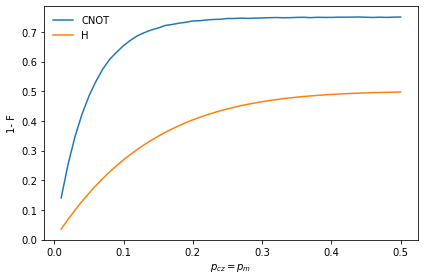

In [122]:
# plt.plot(pc_list,1-np.real(np.array(fids)),)

plt.plot(pc_list,1-np.real(np.array(fids_mc)),label="CNOT")
plt.plot(pc_list,1-Fid_H,label="H")


# print(z)
# plt.plot(pc_list,z[0]*pc_list+z[1],"k--")
# plt.ylim(0,0.8)

# plt.plot(pc_list,1/4+0*pc_list,"k--")
plt.legend(frameon=False)
plt.xlabel(r"$p_{cz}=p_m$")
plt.ylabel("1- F")
plt.tight_layout()       
# plt.savefig("figs/fidelity_pm_eq_pc.pdf")
plt.show()